The information contained in this csv file was taken from actual office records. The exact date of birth within the month was randomly changed for all entries due to HIPAA regulations. 
BMI is Body Mass Index. The next two columns are Date of Birth and Sex. The columns which follow represent whether there was the presence of non-insulin 
dependent diabetes mellitus, insulin dependent diabetes melitus, peripheral vascular disease (as evidenced by one or two non-palpable pedal pulses, 
skin atrophy, decreased hair, and nail changes), neuropathy (as evidenced by decreased sensation of the 5.07 Semmes-Weinstein monofilament fiber), 
the presence of hyperkeratosis (callus), the presence of an ulcer, the presence of cellulitis, and the first dates that these occurred. 'M' is male, 
'F' is female, 'Y' is yes, 'N' is no. Within the 'Smoking' column 'N' is never smoked, 'F' is former smoker, 'C' is current smoker, 
and 'E' means no data was available.

The purpose of this study is to compare how various classifiers compare and  can be utilized as part of an supervised learning model for an office setting. The results utilizing two ensemble classifiers (voting and random forest) are also given. At the end there is a summary of the results from each of the classifiers.

There was no retrievable data on previous history of ulceration or cellulitis.
Instead of NIDDM and IDDM columns there could have been a column for one or the other with a 1 representing the presence of that type and a 0 representing the absence. This would be possible since only diabetics were included in this study. Fitting the model on data that contains that information regarding
first ulceration date or first cellulitis date would have produced more accurate results. In addition, only approximately 760 records of diabetic patients were available.

This file demonstrates how various classifiers can be utilized in an a clinical setting. A larger data set would increase the accuracy of the model. Please refer to the file where a keras model was utilized and demonstrated worse results due to the small size of the data set. The results could be different with a much larger data set. This larger data set could be obtained from a larger office or from an amalgamation of offices. In addition, the EHR could be specifically designed to capture the information which will be utilized in creating the data set. The target is the 'Ulcer' column with the goal of the model being the identification of those diabetic patients likely to develop ulcerations.These patients would then receive supplemental instructions and observation.


In [0]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# The is file opened as a DataFrame, the first 5 rows are observed, and the data type of each column is determined.
df = pd.read_csv(r'https://raw.githubusercontent.com/DavidNNussbaum/office-diabetics/master/OfficeDiabetics.csv')
print(df.head())  
print(df.dtypes)

    BMI         DOB Sex  ... Unnamed: 13 Unnamed: 14 Unnamed: 15
0  28.2  10/11/1938   F  ...         NaN         NaN         NaN
1         6/14/1957   F  ...         NaN         NaN         NaN
2  40.7   4/23/1966   M  ...         NaN         NaN         NaN
3  38.4   3/11/1967   F  ...         NaN         NaN         NaN
4  29.8  10/14/1939   M  ...         NaN         NaN         NaN

[5 rows x 16 columns]
BMI                 object
DOB                 object
Sex                 object
NIDDM               object
IDDM                object
PVD                 object
Neuro               object
Hyper               object
Ulcer               object
Cellulitis          object
Ulcer Date          object
Smoking             object
Cellulitis Date     object
Unnamed: 13        float64
Unnamed: 14        float64
Unnamed: 15         object
dtype: object


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Eliminate 'Unnamed' columns.
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Eliminate any white spaces in column names
for column_name in df.columns:
    try:
        df[column_name] = df[column_name].str.strip()
    except AttributeError:  #This means that this error won't stop it
        pass
print(df.head())

    BMI         DOB Sex NIDDM  ... Cellulitis Ulcer Date Smoking Cellulitis Date
0  28.2  10/11/1938   F     Y  ...        NaN        NaN       F             NaN
1         6/14/1957   F   NaN  ...        NaN        NaN       N             NaN
2  40.7   4/23/1966   M     Y  ...        NaN        NaN       C             NaN
3  38.4   3/11/1967   F   NaN  ...          Y        NaN       N       5/20/2019
4  29.8  10/14/1939   M     Y  ...        NaN        NaN       C             NaN

[5 rows x 13 columns]


In [0]:
# Replace the areas where there are no entries with 0 and a "Y" with a 1 in 6 of the columns.  
# Note that there was one entry in the 'Ulcer' column which was 'I' but should have been 'Y'. This is being corrected. 
# Those with no entry (either NaN or nothing) in the 'Smoking' column were replaced with 'E'. 
# df['Column Name'].unique() was used later on when it was indicated that there were non-integers. These are being corrected here.
# In the 'Sex' column replace 'F' with 0 and 'M' with 1.
df['NIDDM'] = df['NIDDM'].replace(np.NaN, 0, regex=True) 
df['NIDDM'] = df['NIDDM'].replace('Y', 1, regex=True) 
df['IDDM'] = df['IDDM'].replace(np.NaN, 0, regex=True) 
df['IDDM'] = df['IDDM'].replace('nan', 0, regex=True) 
df['IDDM'] = df['IDDM'].replace('Y', 1, regex=True) 
df['PVD'] = df['PVD'].replace(np.NaN, 0, regex=True) 
df['PVD'] = df['PVD'].replace('Y', 1, regex=True) 
df['PVD'] = df['PVD'].replace('nan', 0, regex=True) 
df['Neuro'] = df['Neuro'].replace(np.NaN, 0, regex=True)
df['Neuro'] = df['Neuro'].replace('Y', 1, regex=True)  
df['Neuro'] = df['Neuro'].replace('nan', 0, regex=True) 
df['Hyper'] = df['Hyper'].replace(np.NaN, 0, regex=True)
df['Hyper'] = df['Hyper'].replace('Y', 1, regex=True) 
df['Hyper'] = df['Hyper'].replace('nan', 0, regex=True) 
df['Ulcer'] = df['Ulcer'].replace(np.NaN, 0, regex=True)
df['Ulcer'] = df['Ulcer'].replace('I', 1, regex=True)
df['Ulcer'] = df['Ulcer'].replace('', 0, regex=True)
df['Ulcer'] = df['Ulcer'].replace('Y', 1, regex=True)
df['Sex'] = df['Sex'].replace('F', 0, regex=True)
df['Sex'] = df['Sex'].replace('M', 1, regex=True)
df['Cellulitis'] = df['Cellulitis'].replace(np.NaN, 0, regex=True) 
df['Cellulitis'] = df['Cellulitis'].replace('Y', 1, regex=True) 
df['Cellulitis'] = df['Cellulitis'].replace('nan', 0, regex=True) 
df['Smoking'] = df['Smoking'].replace(np.NaN, 'E', regex=True) 
df['Smoking'] = df['Smoking'].replace('', 'E', regex=True)

In the assembling of the ensemble there was an error message regarding the presence of non-integers. If the data set had been larger those rows would just have been dropped. Since there are only 761 rows, and the correct information was obtainable, the non-integers were corrected. The first two codes (which are now commented out) were used to respectively determine the number of rows and names of the columns.) The third and fourth codes (also commented out)
were used to consecutively print 50 rows at a time (printing more than 50 rows would not have allowed all of them to be visible) bringing up rows to examine them. The columns were divided so that all would be visable. The corrections were then made.
The 'Ulcer Date', 'Smoking' and "Cellulitis Date' columns will be dealt with later.

In [0]:
# print(df.shape)
# print(df.columns)
# print(df.loc[0:50, 'DOB':'Neuro'])
# print(df.loc[0:50, 'Hyper':'Cellulitis'])
df['DOB'].loc[397] = '12/11/1955'
df['DOB'].loc[400] = '02/07/1946'
df['DOB'].loc[529] = '02/04/1957'
df['DOB'].loc[541] = '02/19/1929'
df['PVD'].loc[[18, 122, 215]] = 0
df['PVD'].loc[[147]] = 1
df['Hyper'].loc[215, 217] = 0
df['Hyper'].loc[147, 274] = 1
df['IDDM'].loc[[18, 292, 427, 526, 543]] = 0
df['Neuro'].loc[[526, 533, 543]] = 0
df['Cellulitis'].loc[[5, 93, 110, 140, 481]] = 1
df['Cellulitis'].loc[[292, 307, 732]] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# Fill in blanks in the 'Ulcer Date' and the 'Cellulitis Date' columns with one of the last data retrieval dates.
df['Ulcer Date'] = df['Ulcer Date'].replace(np.NaN, '03/31/2020')
df['Cellulitis Date'] = df['Cellulitis Date'].replace(np.NaN, '03/31/2020')
print(df['Ulcer Date'].head())
print(df['Cellulitis Date'].head())

0    03/31/2020
1    03/31/2020
2    03/31/2020
3    03/31/2020
4    03/31/2020
Name: Ulcer Date, dtype: object
0    03/31/2020
1    03/31/2020
2    03/31/2020
3     5/20/2019
4    03/31/2020
Name: Cellulitis Date, dtype: object


In [0]:
# Determine current Data Frame shape
print(df.shape)

(761, 13)


In [0]:
# Convert 'DOB', "Ulcer Date', and 'Cellulitis Date' columns to datetime64 after ensuring that they all have hyphens instead of lines.
df[['DOB', 'Ulcer Date', 'Cellulitis Date']] = \
    df[['DOB', 'Ulcer Date', 'Cellulitis Date']].replace('/', '-', regex=True)  
df[['DOB', 'Ulcer Date', 'Cellulitis Date']] = \
    pd.to_datetime(df[['DOB', 'Ulcer Date', 'Cellulitis Date']].stack(), format="%m-%d-%Y", errors='coerce').unstack()
# Ensure that the three columns are of type datetime64
print(df[['DOB', 'Ulcer Date', 'Cellulitis Date']].dtypes)
# Determine which of the 'DOB' column entries are not datetime64
print(df[df['DOB'].isnull()])

DOB                datetime64[ns]
Ulcer Date         datetime64[ns]
Cellulitis Date    datetime64[ns]
dtype: object
Empty DataFrame
Columns: [BMI, DOB, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, Ulcer Date, Smoking, Cellulitis Date]
Index: []


In [0]:
# Create new columns for age in years age achieved without an ulcer or cellulitis recorded. 
df['CellulitisAge'] = ((df['Cellulitis Date'] - (df['DOB'])) / timedelta(days=365))
df['UlcerAge'] = ((df['Ulcer Date'] - (df['DOB'])) / timedelta(days=365))
# Determine if there are any rows with Nan and eliminate them.
print(df[df['CellulitisAge'].isnull()])
print(df[df['UlcerAge'].isnull()])
# Eliminate rows in 'UlcerAge' which do not have values.
df = df.dropna(subset=['UlcerAge'])
# Confirm shape of df.
print(df.shape)
# Change the data type of the new columns to int64 
df['CellulitisAge'] = df['CellulitisAge'].astype('object').astype(np.int64)
df['UlcerAge'] = df['UlcerAge'].astype('object').astype('int64')
# The DOB, Cellulitis Date, and Ulcer Date columns are then dropped.
df = df.drop(['DOB', 'Cellulitis Date', 'Ulcer Date'], axis=1)
print(df.head())

Empty DataFrame
Columns: [BMI, DOB, Sex, NIDDM, IDDM, PVD, Neuro, Hyper, Ulcer, Cellulitis, Ulcer Date, Smoking, Cellulitis Date, CellulitisAge, UlcerAge]
Index: []
      BMI        DOB  Sex  ...  Cellulitis Date CellulitisAge UlcerAge
246  29.2 1938-01-11    0  ...       2020-03-31     82.273973      NaN
476  37.6 1949-07-06    1  ...       2020-03-31     70.783562      NaN

[2 rows x 15 columns]
(759, 15)
    BMI  Sex  NIDDM IDDM PVD  ... Ulcer Cellulitis  Smoking CellulitisAge UlcerAge
0  28.2    0      1    0   1  ...     0          0        F            81       81
1          0      0    1   0  ...     0          0        N            62       62
2  40.7    1      1    0   0  ...     0          0        C            53       53
3  38.4    0      0    1   0  ...     0          1        N            52       53
4  29.8    1      1    0   1  ...     0          0        C            80       80

[5 rows x 12 columns]


In [0]:
# Change the 'BMI' column from object to float64.
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')
print(df['BMI'].dtypes)

float64


In [0]:
# The 'IDDM','PVD', 'Neuro', 'Hyper', and 'Cellulitis' columns are converted to int64.
df['IDDM'] = df['IDDM'].astype('object').astype('int64')
df['PVD'] = df['PVD'].astype('object').astype('int64')
df['Neuro'] = df['Neuro'].astype('object').astype('int64')
df['Hyper'] = df['Hyper'].astype('object').astype('int64')
df['Cellulitis'] = df['Cellulitis'].astype('object').astype('int64')
print(df.dtypes)

BMI              float64
Sex                int64
NIDDM              int64
IDDM               int64
PVD                int64
Neuro              int64
Hyper              int64
Ulcer              int64
Cellulitis         int64
Smoking           object
CellulitisAge      int64
UlcerAge           int64
dtype: object


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# The 'Smoking' column is being changed from string to numerical
le = LabelEncoder() 
df['Smoking']= le.fit_transform(df['Smoking'])
print(df.head())

    BMI  Sex  NIDDM  IDDM  ...  Cellulitis  Smoking  CellulitisAge  UlcerAge
0  28.2    0      1     0  ...           0        2             81        81
1   NaN    0      0     1  ...           0        3             62        62
2  40.7    1      1     0  ...           0        0             53        53
3  38.4    0      0     1  ...           1        3             52        53
4  29.8    1      1     0  ...           0        0             80        80

[5 rows x 12 columns]


In [0]:
# The 'Smoking' column is more than binary so one hot encoding must be done.
du = pd.get_dummies(df['Smoking'], columns=['Smoking'], prefix='Smoke')
df = pd.concat([df, du], axis=1)
df = df.drop(['Smoking'], axis=1)
print(df.head())

    BMI  Sex  NIDDM  IDDM  PVD  ...  UlcerAge  Smoke_0  Smoke_1  Smoke_2  Smoke_3
0  28.2    0      1     0    1  ...        81        0        0        1        0
1   NaN    0      0     1    0  ...        62        0        0        0        1
2  40.7    1      1     0    0  ...        53        1        0        0        0
3  38.4    0      0     1    0  ...        53        0        0        0        1
4  29.8    1      1     0    1  ...        80        1        0        0        0

[5 rows x 15 columns]


In [0]:
# # The 'Ulcer' column contains integers and strings that must ne changed to all integers.
# print(df['Ulcer'].dtypes)
# df['Ulcer'] = df['Ulcer'].astype(int)
# print(df['Ulcer'].dtypes)
# print(df['Ulcer'].unique())

In [0]:
df.columns

Index(['BMI', 'Sex', 'NIDDM', 'IDDM', 'PVD', 'Neuro', 'Hyper', 'Ulcer',
       'Cellulitis', 'CellulitisAge', 'UlcerAge', 'Smoke_0', 'Smoke_1',
       'Smoke_2', 'Smoke_3'],
      dtype='object')

In [0]:
# The missing BMI values for those with ulcers will be filled in with the mean of those having ulcers.
# The missing BMI values for those without ulcers will be filled in with the mean of those not having ulcers.
mean0, mean1 = df.groupby('Ulcer').mean()['BMI'].values
for i, row in df.iterrows():
  if row['Ulcer'] == 0 and np.isnan(row['BMI']):
    df.loc[i, 'BMI'] = mean0
  elif row['Ulcer'] == 1 and np.isnan(row['BMI']):
    df.loc[i, 'BMI'] = mean1
print(df['BMI'].head())

0    28.200000
1    33.942791
2    40.700000
3    38.400000
4    29.800000
Name: BMI, dtype: float64


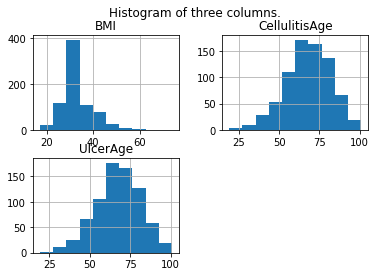

In [0]:
# Create a histogram of the 'BMI', 'UlcerAge', and CellulitisAge columns.
df[['BMI', 'UlcerAge', 'CellulitisAge']].hist()
plt.suptitle('Histogram of three columns.')
plt.show()
# It is interesting to note that the CellulitisAge and UlcerAge features both peak at approximately age 60.
# The BMI peaks at approximately 30. 

<Figure size 864x432 with 0 Axes>

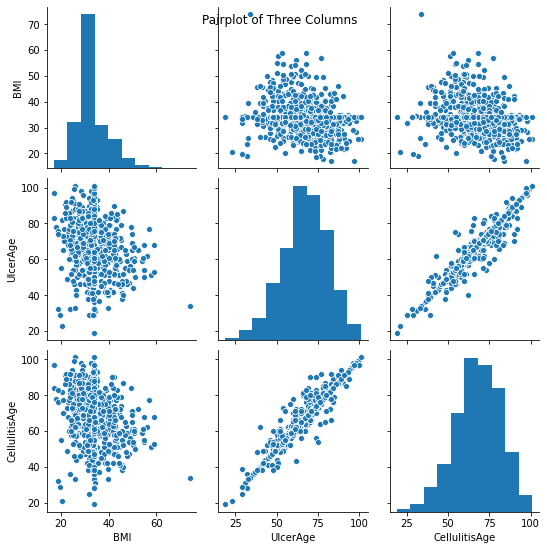

In [0]:
# Create a pairplot of the 'BMI', 'UlcerAge', and CellulitisAge columns.
plt.figure(figsize=(12, 6))
sns.pairplot(df[['BMI', 'UlcerAge', 'CellulitisAge']])
plt.suptitle('Pairplot of Three Columns')
plt.show()
# The pairplot confirms the linear relationship between UlcerAge and CellulitisAge and the non-liear relationship
# between those two and the BMI.

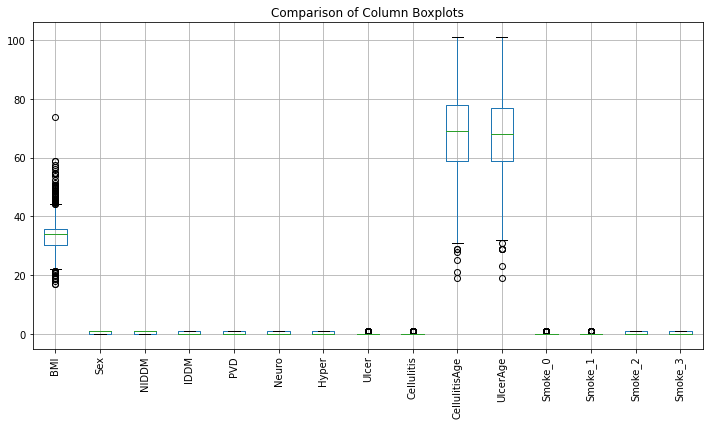

In [0]:
# Create a boxplot of the columns. In the next cell, the boxplot of 'UlcerAge' will be examined.
plt.figure(figsize=(12, 6))
df.boxplot()
plt.title('Comparison of Column Boxplots')
plt.xticks(rotation=90)
plt.show()

Create two boxplots, the first of the 'UlcerAge' column and the second of the same column with the extremes trimmed. 
The same could be done with 'BMI' and 'CellulitisAge', however if all entries with extreme values in any of these three columns were removed 
there would be several hundred fewer entries. This would be feasible in a much larger data set.

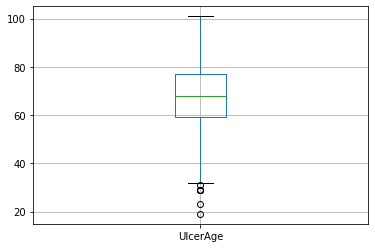

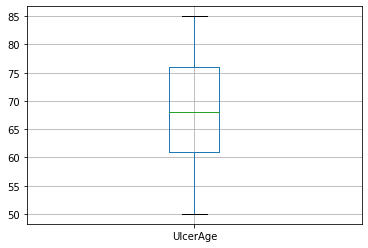

(605, 15)


In [0]:
df[['UlcerAge']].boxplot()
plt.show()
std = df['UlcerAge'].std()
mean = df['UlcerAge'].mean()
cut_off = df['UlcerAge'].quantile(0.75) - df['UlcerAge'].quantile(0.25) # Can also do std * 3
lower, upper = mean - cut_off, mean + cut_off
trimmed_df = df[(df['UlcerAge'] < upper)
                           & (df['UlcerAge'] > lower)]
trimmed_df[['UlcerAge']].boxplot()
plt.show()
print(trimmed_df.shape)

In [0]:
# X and y are formed, X is standardized, and training and testing sets are created.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# The features and target are separated into 'X' and 'y' and 'X' is standardized
y = df['Ulcer'].copy().values #values makes dataframe into array to correct if order changes lose column names and index
X = df.drop(['Ulcer'], axis=1).copy().values
SS_scaler = StandardScaler()
X = SS_scaler.fit_transform(X)
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

The optimal number of neighbors will be determined for the K-Nearest Neighbors classifier. The K-Nearest Neighbors classifier will be instantiated and fitted. The metrics will then be determined.

In [0]:
# We will optomize our three classifiers and then institute voting to achieve the best results
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, log_loss, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
 
# Creating even list K for KNN.
neighbors = list(range(2,50,2))
# empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn,X_train,y_train,cv = 10,scoring =
    "accuracy")
    cv_scores.append(scores.mean())

# Change to mse classification error.
mse = [1-x for x in cv_scores]
# determing best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}.".format(optimal_k))

The optimal no. of neighbors is 12.


In [0]:
# Instantiate and fit the K-Nearest Neighbors classifier.
clf_knn = KNeighborsClassifier(n_neighbors=10)
clf_knn.fit(X_train, y_train)
knn_pred = clf_knn.predict(X_test)

# Compare the K-Nearest Neighbors training and test accuracies.
knn_pred_train_Y = clf_knn.predict(X_train)
knn_pred_test_Y = clf_knn.predict(X_test)
knn_train_accuracy = round(accuracy_score(y_train, knn_pred_train_Y), 3)
knn_test_accuracy = round(accuracy_score(y_test, knn_pred_test_Y), 3)
print('K-Nearest Neighbors Training Accuracy:', knn_train_accuracy)
print('K-Nearest Neighbors Test Accuracy:', knn_test_accuracy)

# Compare the K-Nearest Neighbors training and test precision and recall.
knn_train_precision = round(precision_score(y_train, knn_pred_train_Y), 3)
knn_test_precision = round(precision_score(y_test, knn_pred_test_Y), 3)
knn_train_recall = round(recall_score(y_train, knn_pred_train_Y), 3)
knn_test_recall = round(recall_score(y_test, knn_pred_test_Y), 3)
print('K-Nearest Neighbors Training precision: {}, Training recall: {}'.format(knn_train_precision, knn_train_recall))
print('K-Nearest Neighbors Test precision: {}, Test recall: {}'.format(knn_test_precision, knn_test_recall))

# Calculate the F1-Score of the K-Nearest Neighbors classifier.
score_knn = f1_score(y_test, knn_pred)
print('K-Nearest Neighbors F1-Score: {:.3f}'.format(score_knn))

# Calculate the mean absolute error of the K-Nearest Neighbors classifier.
mae_knn = mean_absolute_error(y_test, knn_pred)
print('K-Nearest Neighbors Log Loss: {:.3f}'.format(mae_knn))

# Calculate the root mean square error of the K-Nearest Neighbors classifier.
rmse_knn = mean_squared_error(y_test, knn_pred)
print('K-Nearest Neighbors Root Mean Absolut Error: {:.3f}'.format(rmse_knn))

# Calculate the log loss of the K-Nearest Neighbors classifier.
ll_knn = log_loss(y_test, knn_pred)
print('K-Nearest Neighbors Log Loss: {:.3f}'.format(ll_knn))

# Calculate the classification report for the K-Nearest Neighbors classifier.
report_knn = classification_report(y_test, knn_pred)
print('K-Nearest Neighbors Classification Report:')
print(report_knn)

# Create a confusion matrix for the K-Nearest Neighbors classifier.
conf_mat_knn = confusion_matrix(y_test, knn_pred)
print('K-Nearest Neighbors Confusion Matrix:')
print(conf_mat_knn)


K-Nearest Neighbors Training Accuracy: 0.811
K-Nearest Neighbors Test Accuracy: 0.822
K-Nearest Neighbors Training precision: 0.683, Training recall: 0.215
K-Nearest Neighbors Test precision: 0.375, Test recall: 0.12
K-Nearest Neighbors F1-Score: 0.182
K-Nearest Neighbors Log Loss: 0.178
K-Nearest Neighbors Root Mean Absolut Error: 0.178
K-Nearest Neighbors Log Loss: 6.135
K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       127
           1       0.38      0.12      0.18        25

    accuracy                           0.82       152
   macro avg       0.61      0.54      0.54       152
weighted avg       0.77      0.82      0.78       152

K-Nearest Neighbors Confusion Matrix:
[[122   5]
 [ 22   3]]


In [0]:
# Determine the K-Nearest Neighbors cross validation score.  
def knn_scorer(clf_knn, X, y):
  return accuracy_score(y, clf_knn.predict(X))
# Check how the K-Nearest Neighbors classifier performs with 5 fold cross-validation.
knn_kfold = cross_val_score(clf_knn, X, y, cv=5, scoring=knn_scorer)
# Print the K-Nearest Neighbors mean accuracy per fold.
print('K-Nearest Neighbors Mean Accuracy Per Fold:', knn_kfold.mean())
# Print the K-Nearest Neighbors standard deviation per fold.
print('K-Nearest Neighbors Standard Deviation Per Fold:', knn_kfold.std())

K-Nearest Neighbors Mean Accuracy Per Fold: 0.799738584872778
K-Nearest Neighbors Standard Deviation Per Fold: 0.00304717804183953


The optimal value of C will be determined for the Logistic Regression classifier. The trade-off parameter of logistic regression that determines the strength of the regularization is called C, 
and higher values of C correspond to less regularization (where we can specify the regularization function).
C is actually the Inverse of regularization strength(lambda) 
liblinear — Library for Large Linear Classification. It uses a coordinate descent algorithm. Coordinate descent is based on 
minimizing a multivariate function by solving univariate optimization problems in a loop. - it is included here so that one can have flexibility for small and large data sets. The Logistic Regression classifier will be instantiated and fitted. The metrics will then be determined.

In [0]:
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 3))
l1_metrics[:,0] = C
 # Run a for loop over the range of C list length
for index in range(0, len(C)):
  # Initialize and fit Logistic Regression with the C candidate
  logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')
  logreg.fit(X_train, y_train)
  # Predict ulcers on the testing data
  pred_test_Y = logreg.predict(X_test)
  # Create non-zero count and recall score columns
  l1_metrics[index,1] = np.count_nonzero(logreg.coef_)
  l1_metrics[index,2] = recall_score(y_test, pred_test_Y)

# Name the columns and print the array as a pandas DataFrame.
col_names = ['C','Non-Zero Coeffs','Recall']
print(pd.DataFrame(l1_metrics, columns=col_names))

        C  Non-Zero Coeffs  Recall
0  1.0000             12.0    0.56
1  0.5000             12.0    0.56
2  0.2500             11.0    0.52
3  0.1000              9.0    0.44
4  0.0500              8.0    0.16
5  0.0250              2.0    0.00
6  0.0100              0.0    0.00
7  0.0050              0.0    0.00
8  0.0025              0.0    0.00


In [0]:
# Instantiate and fit the Logistic Regression classifier.
clf_lr = LogisticRegression(class_weight='balanced', penalty='l1', C=0.2500, solver='liblinear', random_state=500)
clf_lr.fit(X_train, y_train)
lr_pred = clf_lr.predict(X_test)

# Compare the Logistic Regression training and test accuracies.
lr_pred_train_Y = clf_lr.predict(X_train)
lr_pred_test_Y = clf_lr.predict(X_test)
lr_train_accuracy = round(accuracy_score(y_train, lr_pred_train_Y), 3)
lr_test_accuracy = round(accuracy_score(y_test, lr_pred_test_Y), 3)
print('Logistic Regression Training Accuracy:', lr_train_accuracy)
print('Logistic Regression Test Accuracy:', lr_test_accuracy)

# Compare the Logistic Regression training and test precision and recall.
lr_train_precision = round(precision_score(y_train, lr_pred_train_Y), 3)
lr_test_precision = round(precision_score(y_test, lr_pred_test_Y), 3)
lr_train_recall = round(recall_score(y_train, lr_pred_train_Y), 3)
lr_test_recall = round(recall_score(y_test, lr_pred_test_Y), 3)
print('Training precision: {}, Training recall: {}'.format(lr_train_precision, lr_train_recall))
print('Test precision: {}, Test recall: {}'.format(lr_test_precision, lr_test_recall))

# Calculate the F1-Score of the Logistic Regression classifier.
score_lr = f1_score(y_test, lr_pred)
print('Logistic Regression F1-Score: {:.3f}'.format(score_lr))

# Calculate the mean absolute error of the Logistic Regression classifier.
mae_lr = mean_absolute_error(y_test, lr_pred)
print('Logistic Regression Log Loss: {:.3f}'.format(mae_lr))

# Calculate the root mean square error of the Logistic Regression classifier.
rmse_lr = mean_squared_error(y_test, lr_pred)
print('Logistic Regression Root Mean Absolut Error: {:.3f}'.format(rmse_lr))

# Calculate the log loss of the Logistic Regression classifier.
ll_lr = log_loss(y_test, lr_pred)
print('Logistic Regression Log Loss: {:.3f}'.format(ll_lr))

# Calculate the classification report for the Logistic Regression classifier.
report_lr = classification_report(y_test, lr_pred)
print('Logistic Regression Classification Report:')
print(report_lr)

# Create a confusion matrix for the Logistic Regression classifier.
conf_mat_lr = confusion_matrix(y_test, lr_pred)
print('Logistic Regression Confusion Matrix:')
print(conf_mat_lr)

Logistic Regression Training Accuracy: 0.937
Logistic Regression Test Accuracy: 0.914
Training precision: 0.838, Training recall: 0.877
Test precision: 0.714, Test recall: 0.8
Logistic Regression F1-Score: 0.755
Logistic Regression Log Loss: 0.086
Logistic Regression Root Mean Absolut Error: 0.086
Logistic Regression Log Loss: 2.954
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       127
           1       0.71      0.80      0.75        25

    accuracy                           0.91       152
   macro avg       0.84      0.87      0.85       152
weighted avg       0.92      0.91      0.92       152

Logistic Regression Confusion Matrix:
[[119   8]
 [  5  20]]


In [0]:
# Determine the Logistic Regression cross validation score.  
def lr_scorer(clf_lr, X, y):
  return accuracy_score(y, clf_lr.predict(X))
# Check how the Logistic Regression classifier performs with 5 fold cross-validation.
lr_kfold = cross_val_score(clf_lr, X, y, cv=5, scoring=lr_scorer)
# Print the Logistic Regression mean accuracy per fold.
print('Logistic Regression Mean Accuracy Per Fold:', lr_kfold.mean())
# Print the Logistic Regression standard deviation per fold.
print('Logistic Regression Standard Deviation Per Fold:', lr_kfold.std())

Logistic Regression Mean Accuracy Per Fold: 0.91313175322412
Logistic Regression Standard Deviation Per Fold: 0.03510902806716738


The maximal depth will be determined for the Decision Tree classifier. The Decision Tree classifier will be instantiated and fitted. The metrics will then be determined.

In [0]:
depth_list = list(range(2,14))
depth_tuning = np.zeros((len(depth_list), 2))
depth_tuning[:,0] = depth_list

# Run a for loop over the range of depth list length.
for index in range(0, len(depth_list)):
  # Initialize and fit decision tree with the `max_depth` candidate.
  decide = DecisionTreeClassifier(max_depth=depth_list[index])  
  decide.fit(X_train, y_train)
  # Predict ulcers on the testing data.
  ex_pred_test_Y = decide.predict(X_test)
  # Calculate the recall score 
  depth_tuning[index,1] = recall_score(y_test, ex_pred_test_Y)

# Name the columns and print the array as a pandas DataFrame.
col_names = ['Max_Depth','Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))


    Max_Depth  Recall
0         2.0    0.40
1         3.0    0.16
2         4.0    0.36
3         5.0    0.40
4         6.0    0.48
5         7.0    0.44
6         8.0    0.56
7         9.0    0.56
8        10.0    0.48
9        11.0    0.48
10       12.0    0.48
11       13.0    0.48


In [0]:
# Instantiate and fit the Decision Tree classifier.
clf_dt = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=4, max_depth=11, random_state=500)
clf_dt.fit(X_train, y_train)
dt_pred = clf_dt.predict(X_test)

# Compare the Decision Tree training and test accuracies.
dt_pred_train_Y = clf_dt.predict(X_train)
dt_pred_test_Y = clf_dt.predict(X_test)
dt_train_accuracy = accuracy_score(y_train, dt_pred_train_Y)
dt_test_accuracy = accuracy_score(y_test, dt_pred_test_Y)
print('Decision Tree Training Accuracy:', dt_train_accuracy)
print('Decision Tree Test Accuracy:', dt_test_accuracy)

# Compare the Decision Tree training and test precision and recall.
dt_train_precision = round(precision_score(y_train, dt_pred_train_Y), 3)
dt_test_precision = round(precision_score(y_test, dt_pred_test_Y), 3)
dt_train_recall = round(recall_score(y_train, dt_pred_train_Y), 3)
dt_test_recall = round(recall_score(y_test, dt_pred_test_Y), 3)
print('Decision Tree Training precision: {}, Training recall: {}'.format(dt_train_precision, dt_train_recall))
print('Decision Tree Test precision: {}, Test recall: {}'.format(dt_test_precision, dt_test_recall))

# Calculate the F1-Score of the Decision Tree classifier.
score_dt = f1_score(y_test, dt_pred)
print('Decision Tree F1-Score: {:.3f}'.format(score_dt))

# Calculate the mean absolute error of the Decision Tree classifier.
mae_dt = mean_absolute_error(y_test, dt_pred)
print('Decision Tree Log Loss: {:.3f}'.format(mae_dt))

# Calculate the root mean square error of the Decision Tree classifier.
rmse_dt = mean_squared_error(y_test, dt_pred)
print('Decision Tree Root Mean Absolute Error: {:.3f}'.format(rmse_dt))

# Calculate the log loss of the Decision Tree classifier.
ll_dt = log_loss(y_test, dt_pred)
print('Decision Tree Log Loss: {:.3f}'.format(ll_dt))

# Calculate the classification report for the Decision Tree classifier.
report_dt = classification_report(y_test, dt_pred)
print('Decision Tree Classification Report:')
print(report_dt)

# Create a confusion matrix for the Decision Tree classifier.
conf_mat_dt = confusion_matrix(y_test, dt_pred)
print('Decision Tree Confusion Matrix:')
print(conf_mat_dt)


Decision Tree Training Accuracy: 0.9489291598023064
Decision Tree Test Accuracy: 0.8618421052631579
Decision Tree Training precision: 0.884, Training recall: 0.877
Decision Tree Test precision: 0.577, Test recall: 0.6
Decision Tree F1-Score: 0.588
Decision Tree Log Loss: 0.138
Decision Tree Root Mean Absolute Error: 0.138
Decision Tree Log Loss: 4.772
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       127
           1       0.58      0.60      0.59        25

    accuracy                           0.86       152
   macro avg       0.75      0.76      0.75       152
weighted avg       0.86      0.86      0.86       152

Decision Tree Confusion Matrix:
[[116  11]
 [ 10  15]]


In [0]:
# Determine the Decision Tree cross validation score.  
def dt_scorer(clf_dt, X, y):
  return accuracy_score(y, clf_dt.predict(X))
# Check how the Decision Tree classifier performs with 5 fold cross-validation.
dt_kfold = cross_val_score(clf_dt, X, y, cv=5, scoring=dt_scorer)
# Print the Decision Tree mean accuracy per fold.
print('Decision Tree Mean Accuracy Per Fold:', dt_kfold.mean())
# Print the Decision Tree standard deviation per fold.
print('Decision Tree Standard Deviation Per Fold:', dt_kfold.std())

Mean Accuracy Per Fold: 0.8300801673056813
Standard Deviation Per Fold: 0.031064947054359266


The Support Vector Machine classifier will be instantiated and fitted. The metrics will then be determined.  Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. 
 However,  it is mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in n-dimensional space 
 (where n is number of features you have) with the value of each feature being the value of a particular coordinate. 
 Then, we perform classification by finding the hyper-plane that differentiates the two classes very well. Support Vectors are simply the co-ordinates of individual observation. 
The SVM classifier is a frontier which best segregates the two classes (hyper-plane/ line).

In [0]:
# Instantiate and fit the Support Vector Machine classifier.
clf_svm = SVC(probability=True, class_weight='balanced', random_state=500)
clf_svm.fit(X_train, y_train)
svm_pred = clf_svm.predict(X_test)

# Compare the Support Vector Machine training and test accuracies.
svm_pred_train_Y = clf_svm.predict(X_train)
svm_pred_test_Y = clf_svm.predict(X_test)
svm_train_accuracy = accuracy_score(y_train, svm_pred_train_Y)
svm_test_accuracy = accuracy_score(y_test, svm_pred_test_Y)
print('Support Vector Machine Training Accuracy:', svm_train_accuracy)
print('Support Vector Machine Test Accuracy:', svm_test_accuracy)

# Compare the Support Vector Machine training and test precision and recall.
svm_train_precision = round(precision_score(y_train, svm_pred_train_Y), 3)
svm_test_precision = round(precision_score(y_test, svm_pred_test_Y), 3)
svm_train_recall = round(recall_score(y_train, svm_pred_train_Y), 3)
svm_test_recall = round(recall_score(y_test, svm_pred_test_Y), 3)
print('Support Vector Machine Training precision: {}, Training recall: {}'.format(svm_train_precision, svm_train_recall))
print('Support Vector Machine Test precision: {}, Test recall: {}'.format(svm_test_precision, svm_test_recall))

# Calculate the F1-Score of the Support Vector Machine classifier.
score_svm = f1_score(y_test, svm_pred)
print('Support Vector Machine F1-Score: {:.3f}'.format(score_svm))

# Calculate the mean absolute error of the Support Vector Machine classifier.
mae_svm = mean_absolute_error(y_test, svm_pred)
print('Support Vector Machine Log Loss: {:.3f}'.format(mae_svm))

# Calculate the root mean square error of the Support Vector Machine classifier.
rmse_svm = mean_squared_error(y_test, svm_pred)
print('Support Vector Machine Root Mean Absolute Error: {:.3f}'.format(rmse_svm))

# Calculate the log loss of the Support Vector Machine classifier.
ll_svm = log_loss(y_test, svm_pred)
print('Support Vector Machine Log Loss: {:.3f}'.format(ll_svm))

# Calculate the classification report for the Support Vector Machine classifier.
report_svm = classification_report(y_test, svm_pred)
print('Support Vector Machine Classification Report:')
print(report_svm)

# Create a confusion matrix for the Support Vector Machine classifier.
conf_mat_svm = confusion_matrix(y_test, svm_pred)
print('Support Vector Machine Confusion Matrix:')
print(conf_mat_svm)

Support Vector Machine Training Accuracy: 0.8121911037891268
Support Vector Machine Test Accuracy: 0.7039473684210527
Support Vector Machine Training precision: 0.543, Training recall: 0.777
Support Vector Machine Test precision: 0.308, Test recall: 0.64
Support Vector Machine F1-Score: 0.416
Support Vector Machine Log Loss: 0.296
Support Vector Machine Root Mean Absolute Error: 0.296
Support Vector Machine Log Loss: 10.225
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       127
           1       0.31      0.64      0.42        25

    accuracy                           0.70       152
   macro avg       0.61      0.68      0.61       152
weighted avg       0.81      0.70      0.74       152

Support Vector Machine Confusion Matrix:
[[91 36]
 [ 9 16]]


In [0]:
# Determine the Support Vector Machine cross validation score.  
def svm_scorer(clf_svm, X, y):
  return accuracy_score(y, clf_svm.predict(X))
# Check how the Support Vector Machine performs with 5 fold cross-validation
svm_kfold = cross_val_score(clf_svm, X, y, cv=5, scoring=svm_scorer)
# Print the Support Vector Machine mean accuracy per fold
print('Support Vector Machine Mean Accuracy Per Fold:', svm_kfold.mean())
# Print the standard deviation per fold
print('Support Vector Machine Standard Deviation Per Fold:', svm_kfold.std())

Support Vector Machine Mean Accuracy Per Fold: 0.7537120948065528
Support Vector Machine Standard Deviation Per Fold: 0.03985630054247557


The optimal number of neighbors will be determined for the voting classifier. The voting classifier will be instantiated and fitted. The metrics will then be determined.

In [0]:
 # Create and fit the voting classifier.
clf_vote = VotingClassifier(
    estimators=[('knn', clf_knn), ('lr',clf_lr), ('dt', clf_dt), ('svm', clf_svm)]
)
clf_vote.fit(X_train, y_train)
pred_vote = clf_vote.predict(X_test)

# Calculate the F1-Score of the voting classifier.
score_vote = f1_score(y_test, pred_vote)
print('Voting Classifier F1-Score: {:.3f}'.format(score_vote))

# Calculate the mean absolute error of the voting classifier.
mae_vote = mean_absolute_error(y_test, pred_vote)
print('Voting Classifier Log Loss: {:.3f}'.format(mae_vote))

# Calculate the root mean square error of the voting classifier.
rmse_vote = mean_squared_error(y_test, pred_vote)
print('Voting Classifier Root Mean Absolute Error: {:.3f}'.format(rmse_vote))

# Calculate the log loss of the voting classifier.
ll_vote = log_loss(y_test, pred_vote)
print('Voting Classifier Log Loss: {:.3f}'.format(ll_vote))

# Calculate the classification report for the voting classifier.
report_vote = classification_report(y_test, pred_vote)
print('Voting Classifier Classification Report:')
print(report_vote)

# Create a confusion matrix for the voting classifier.
conf_mat_vote = confusion_matrix(y_test, pred_vote)
print('Voting Classifier Confusion Matrix:')
print(conf_mat_vote)

Voting Classifier F1-Score: 0.524
Voting Classifier Log Loss: 0.132
Voting Classifier Root Mean Absolute Error: 0.132
Voting Classifier Log Loss: 4.545
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       127
           1       0.65      0.44      0.52        25

    accuracy                           0.87       152
   macro avg       0.77      0.70      0.72       152
weighted avg       0.86      0.87      0.86       152

Voting Classifier Confusion Matrix:
[[121   6]
 [ 14  11]]


In [0]:
# Determine the voting cross validation score.  
def vote_scorer(clf_vote, X, y):
  return accuracy_score(y, clf_vote.predict(X))
# Check how the voting model performs with 5 fold cross-validation.
vote_kfold = cross_val_score(clf_vote, X, y, cv=5, scoring=vote_scorer)
# Print the mean voting accuracy per fold.
print('Voting Accuracy Per Fold:', vote_kfold.mean())
# Print the voting standard deviation per fold.
print('Voting Standard Deviation Per Fold:', vote_kfold.std())

Voting Accuracy Per Fold: 0.8472028581387242
Voting Standard Deviation Per Fold: 0.019462059223270947


The Random Forest classifier is another ensemble classifier. It will be instantiated and fitted. The metrics will then be determined.

In [0]:
# Instantiate and fit the Random Forest classifier.
clf_rf = RandomForestClassifier(n_estimators=15, max_features=10, oob_score=10 , max_depth=15 ,min_samples_split=4 , min_samples_leaf=4 , class_weight= ('balanced') )  
clf_rf.fit(X_train, y_train)
rf_pred = clf_rf.predict(X_test)

# Compare the Random Forest training and test accuracies.
rf_pred_train_Y = clf_rf.predict(X_train)
rf_pred_test_Y = clf_rf.predict(X_test)
rf_train_accuracy = accuracy_score(y_train, rf_pred_train_Y)
rf_test_accuracy = accuracy_score(y_test, rf_pred_test_Y)
print('Random Forest Training Accuracy:', rf_train_accuracy)
print('Random Forest Test Accuracy:', rf_test_accuracy)

# Compare the Random Forest training and test precision and recall.
rf_train_precision = round(precision_score(y_train, rf_pred_train_Y), 4)
rf_test_precision = round(precision_score(y_test, rf_pred_test_Y), 4)
rf_train_recall = round(recall_score(y_train, rf_pred_train_Y), 4)
rf_test_recall = round(recall_score(y_test, rf_pred_test_Y), 4)
print('Random Forest Training precision: {}, Training recall: {}'.format(rf_train_precision, dt_train_recall))
print('Random Forest Test precision: {}, Test recall: {}'.format(rf_test_precision, dt_test_recall))

# Calculate the F1-Score of the Random Forest classifier.
score_rf = f1_score(y_test, rf_pred)
print('Random Forest F1-Score: {:.3f}'.format(score_rf))

# Calculate the mean absolute error of the Random Forest classifier.
mae_rf = mean_absolute_error(y_test, rf_pred)
print('Random Forest Log Loss: {:.3f}'.format(mae_rf))

# Calculate the root mean square error of the Random Forest classifier.
rmse_rf = mean_squared_error(y_test, rf_pred)
print('Random Forest Root Mean Absolute Error: {:.3f}'.format(rmse_rf))

# Calculate the log loss of the Random Forest classifier.
ll_rf = log_loss(y_test, rf_pred)
print('Random Forest Log Loss: {:.3f}'.format(ll_rf))

# Calculate the classification report for the Random Forest classifier.
report_rf = classification_report(y_test, rf_pred)
print('Random Forest Classification Report:')
print(report_rf)

# Create a confusion matrix for the Random Forest classifier.
conf_mat_rf = confusion_matrix(y_test, rf_pred)
print('Random Forest Confusion Matrix:')
print(conf_mat_rf)

Random Forest Training Accuracy: 0.9522240527182867
Random Forest Test Accuracy: 0.8421052631578947
Random Forest Training precision: 0.8741, Training recall: 0.8769
Random Forest Test precision: 0.52, Test recall: 0.6
Random Forest F1-Score: 0.520
Random Forest Log Loss: 0.158
Random Forest Root Mean Absolute Error: 0.158
Random Forest Log Loss: 5.454
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       127
           1       0.52      0.52      0.52        25

    accuracy                           0.84       152
   macro avg       0.71      0.71      0.71       152
weighted avg       0.84      0.84      0.84       152

Random Forest Confusion Matrix:
[[115  12]
 [ 12  13]]


In [0]:
# Determine the Random Forest cross validation score.  
def rf_scorer(clf_rf, X, y):
  return accuracy_score(y, clf_rf.predict(X))
# Check how the Random Forest model performs with 5 fold cross-validation.
rf_kfold = cross_val_score(clf_rf, X, y, cv=5, scoring=rf_scorer)
# Print the Random Forest mean accuracy per fold.
print('Random Forest Mean Accuracy Per Fold:', rf_kfold.mean())
# Print the Random Forest standard deviation per fold.
print('Random Forest Standard Deviation Per Fold:', rf_kfold.std())

Random Forest Mean Accuracy Per Fold: 0.8524311606831649
Random Forest Standard Deviation Per Fold: 0.019824660340189728


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


The following table contains a summary of the metrics. 

In [0]:
print('Summary of Classifier Results:')
data = {'Classifier':['K-Nearest Neighbors', 'Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Voting', 'Random Forest'],
        'Training Accuracy':[knn_train_accuracy, lr_train_accuracy, dt_train_accuracy, svm_train_accuracy, '', rf_train_accuracy], 
        'Test Accuracy':[knn_test_accuracy, lr_test_accuracy, dt_test_accuracy, svm_test_accuracy, '', rf_test_accuracy], 
        'Training Precision':[knn_train_precision, lr_train_precision, dt_train_precision, svm_train_precision, '', rf_train_precision], 
        'Training Recall':[knn_train_recall, lr_train_recall, dt_train_recall, svm_train_recall, '', rf_train_recall], 
        'Test Precision':[knn_test_precision, lr_test_precision, dt_test_precision, svm_test_precision, '', rf_test_precision], 
        'Test Recall':[knn_test_recall, lr_test_recall, dt_test_recall, svm_test_recall, '', rf_test_recall], 
        'F1-Score':[score_knn, score_lr, score_dt, score_svm, score_vote, score_rf], 
        'Mean Absolute Error':[mae_knn, mae_lr, mae_dt, mae_svm, mae_vote, mae_rf], 
        'Root Mean Square Error':[rmse_knn, rmse_lr, rmse_dt, rmse_svm, rmse_vote, rmse_rf], 
        'Log Loss':[ll_knn, ll_lr, ll_dt, ll_svm, ll_vote, ll_rf], 
        'Cross Validation Mean Accuracy':[knn_kfold.mean(), lr_kfold.mean(), dt_kfold.mean(), svm_kfold.mean(), vote_kfold.mean(), rf_kfold.mean()],
        'Cross Validation Standard Deviation':[knn_kfold.std(), lr_kfold.std(), dt_kfold.std(), svm_kfold.std(), vote_kfold.std(), rf_kfold.std()]}
summary = pd.DataFrame(data)
summary.set_index('Classifier')

Summary of Classifier Results:


,Training Accuracy,Test Accuracy,Training Precision,Training Recall,Test Precision,Test Recall,F1-Score,Mean Absolute Error,Root Mean Square Error,Log Loss,Cross Validation Mean Accuracy,Cross Validation Standard Deviation
Classifier,,,,,,,,,,,,
K-Nearest Neighbors,0.810544,0.822368,0.6829,0.2154,0.375,0.12,0.181818,0.177632,0.177632,6.135204,0.799739,0.003047
Logistic Regression,0.937397,0.914474,0.8382,0.8769,0.7143,0.8,0.754717,0.085526,0.085526,2.954016,0.913132,0.035109
Decision Tree,0.948929,0.861842,0.8837,0.8769,0.5769,0.6,0.588235,0.138158,0.138158,4.771862,0.830080,0.031065
Support Vector Machine,0.812191,0.703947,0.543,0.7769,0.3077,0.64,0.415584,0.296053,0.296053,10.225485,0.753712,0.039856
Voting,,,,,,,0.523810,0.131579,0.131579,4.544607,0.847203,0.019462
Random Forest,0.952224,0.842105,0.8741,0.9077,0.52,0.52,0.520000,0.157895,0.157895,5.453554,0.852431,0.019825


The following is a summary of the classification reports.

In [0]:
print('Review of Classification Reports:')
print('K-Nearest Neighbors Classification Report:')
print(report_knn)
print('Logistic Regression Classification Report:')
print(report_lr)
print('Decision Tree Classification Report:')
print(report_dt)
print('Support Vector Machine Classification Report:')
print(report_svm)
print('Voting Classification Report:')
print(report_vote)
print('Random Forest Classification Report:')
print(report_rf)

Review of Classification Reports:
K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       127
           1       0.38      0.12      0.18        25

    accuracy                           0.82       152
   macro avg       0.61      0.54      0.54       152
weighted avg       0.77      0.82      0.78       152

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       127
           1       0.71      0.80      0.75        25

    accuracy                           0.91       152
   macro avg       0.84      0.87      0.85       152
weighted avg       0.92      0.91      0.92       152

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       127
           1       0.58      0.60      0.59        25

    accuracy             

The following is a summary of the confusion matrices.

In [0]:
print('Review of Confusion Matrices:')
print('K-Nearest Neighbors Confusion Matrix:')
print(conf_mat_knn)
print('Logistic Regression Confusion Matrix:')
print(conf_mat_lr)
print('Decision Tree Confusion Matrix:')
print(conf_mat_dt)
print('Support Vector Machine Confusion Matrix:')
print(conf_mat_svm)
print('Voting Confusion Matrix:')
print(conf_mat_vote)
print('Random Forest Confusion Matrix:')
print(conf_mat_rf)

Review of Confusion Matrices:
K-Nearest Neighbors Confusion Matrix:
[[122   5]
 [ 22   3]]
Logistic Regression Confusion Matrix:
[[119   8]
 [  5  20]]
Decision Tree Confusion Matrix:
[[116  11]
 [ 10  15]]
Support Vector Machine Confusion Matrix:
[[91 36]
 [ 9 16]]
Voting Confusion Matrix:
[[121   6]
 [ 14  11]]
Random Forest Confusion Matrix:
[[115  12]
 [ 12  13]]
